In [1]:
import os
import importlib
import time

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from skimage import transform as skimg_transform
#from skimage import io as img_io
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils, models
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import load_data
import model
import warnings

In [2]:
plt.style.use('Solarize_Light2')
warnings.filterwarnings('ignore')
%matplotlib inline
importlib.reload(load_data)
importlib.reload(model)

<module 'model' from '/home/uldo/work/kaggle/competitions/Humpback_Whale_Identification/code/model.py'>

In [3]:
#BATCH_SIZE = 100
#BATCH_SIZE = 32
#BATCH_SIZE = 200
#BATCH_SIZE = 128
BATCH_SIZE = 64
#BATCH_SIZE = 32
#IMAGE_W = 100
#IMAGE_W = 256
#IMAGE_W = 64
IMAGE_W = 128
#IMAGE_H = 100
#IMAGE_H = 256
#IMAGE_H = 64
IMAGE_H = 128

In [4]:
class HWI_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HWI_ConvNeuralNet, self).__init__()
        '''
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 12, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear(int(12 * IMAGE_W/4 * IMAGE_H/4), 900)
        self.out2 = nn.Linear(900, 1)
        '''
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=2, padding=4)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        #self.fc1 = nn.Linear(int(IMAGE_H * IMAGE_W 131072 x 16), 1024)
        #self.fc1 = nn.Linear(524288 * 64, 1024)
        self.fc1 = nn.Linear(32768 * 16, 1024)
        self.fc2 = nn.Linear(1024, 32)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        
        #forward, input x.size():  torch.Size([64, 3, 256, 256])
        #forward, after F.relu(self.conv1(x)) x.size():  torch.Size([64, 32, 128, 128])
        #forward, after self.pool(x) x.size():  torch.Size([64, 32, 64, 64])
        #forward, after F.relu(self.conv2(x)) x.size():  torch.Size([64, 64, 32, 32])
        #forward, after self.pool(x) x.size():  torch.Size([64, 64, 16, 16])
        #forward, after x.view(-1, 65536 * 16) x.size():  torch.Size([1, 1048576])
        #forward, after F.relu(self.fc1(x)) x.size():  torch.Size([1, 1024])
        #forward, after self.dropout x.size():  torch.Size([1, 1024])
        #forward, after self.fc2 x.size():  torch.Size([1, 1])
        #forward, after self.sigmoid(x) x.size():  torch.Size([1, 1])
        
    def forward(self, x):
        '''
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        #return output, x
        return output[:, 0]
        '''
        #print("forward, input x.size(): ", x.size())
        
        x = F.relu(self.conv1(x))
        #print("forward, after F.relu(self.conv1(x)) x.size(): ", x.size())
        x = self.pool(x)
        #print("forward, after self.pool(x) x.size(): ", x.size())
        x = F.relu(self.conv2(x))
        #print("forward, after F.relu(self.conv2(x)) x.size(): ", x.size())
        x = self.pool(x)     
        #print("forward, after self.pool(x) x.size(): ", x.size())  
        x = x.view(-1, 32768 * 16)
        #print("forward, after x.view(-1, 65536 * 16) x.size(): ", x.size())
        x = F.relu(self.fc1(x))
        #print("forward, after F.relu(self.fc1(x)) x.size(): ", x.size())
        x = self.dropout(x)
        #print("forward, after self.dropout x.size(): ", x.size())
        x = self.fc2(x)
        #print("forward, after self.fc2 x.size(): ", x.size())
        x = self.sigmoid(x)
        #print("forward, after self.sigmoid(x) x.size(): ", x.size())
        return x
        

In [5]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        orig_height, orig_width = image.shape[:2]
        if isinstance(self.output_size, int):
            if orig_height > orig_width:
                new_height, new_width = self.output_size * orig_height / orig_width, self.output_size
            else:
                new_height, new_width = self.output_size, self.output_size * orig_width / orig_height
        else:
            new_height, new_width = self.output_size

        new_height, new_width = int(new_height), int(new_width)

        img = skimg_transform.resize(image, (new_height, new_width))

        return {'image': img, 'label': label}

In [6]:
class UnifyRescale(object):
    
    def __init__(self, output_size=128):
        assert isinstance(output_size, int)
        self.output_size = output_size
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        img = skimg_transform.resize(image, (self.output_size, self.output_size))

        return {'image': img, 'label': label}

In [7]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        orig_height, orig_width = image.shape[:2]
        new_height, new_width = self.output_size

        top = np.random.randint(0, orig_height - new_height)
        left = np.random.randint(0, orig_width - new_width)

        image = image[top: top + new_height, left: left + new_width]

        return {'image': image, 'label': label}

In [8]:
class ToTensor(object):
    
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, image_size=128):
        self.image_size = image_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        """ The original code didn't expect gray scale images """
        
        gray_scale_image = torch.zeros(
            [self.image_size, self.image_size]
        ).shape == image.shape
        if gray_scale_image:
            image = np.stack((image,) * 3, axis=-1)
        
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'label': torch.tensor(label, dtype=torch.uint8)}

In [9]:
def show_whale_batch(sample_batched):
    """Show whales for a batch of samples."""
    images_batch = sample_batched['image']
    labels_batch = sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0))[:, :, 0], cmap='gray')
    
    '''
    for image in images_batch:
        print("image.size()", image.size())
        as_np = image.numpy().transpose((1, 2, 0))[:, :, 0]
        print("as_np.shape", as_np.shape)
        #plt.imshow(image.numpy().transpose((1, 2, 0)))
        plt.imshow(as_np)
    '''
    for i in range(batch_size):
        plt.title('Batch from dataloader')

In [10]:
def prepare_loaders(dataset, valid_train_ratio=0.6):
    dataset_size = len(dataset)
    print("dataset_size: ", dataset_size)

    validation_subset_size = int(dataset_size * (1 - valid_train_ratio))
    print("validation_subset_size: ", validation_subset_size)

    indices = list(range(dataset_size))
    validation_indices = np.random.choice(indices, size=validation_subset_size, replace=False)
    train_indices = list(set(indices) - set(validation_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    dataset_sizes = {
            'train': len(train_indices),
            'validation': len(validation_indices)
        }

    #train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler, pin_memory=True)
    train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler)
    #validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler, pin_memory=True)
    validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler)
    loaders = {
            'train': train_loader,
            'validation': validation_loader
        }

    return loaders, dataset_sizes

In [11]:
def unfold_batch(batch):
    return batch['image'], batch['label']

In [12]:
def one_epoch_train(model, data_loader, criterion, optimizer):
    
    accuracy = 0.0
    total_loss = 0.0
    correct_predicted_total = 0.0
    
    for i, data_batch in enumerate(data_loader, 0):
        #print("one_epoch_model_process, len(data_batch): ", len(data_batch))
        #print("one_epoch_model_process, type(data_batch): ", type(data_batch))        
        
        inputs, labels = unfold_batch(data_batch)
        #print("one_epoch_model_process, inputs.size(): ", inputs.size())
        if inputs.size()[0] == BATCH_SIZE:
            
            
            #print("inputs: ", inputs)
            #print("labels: ", labels)
            #print("inputs.size(): ", inputs.size())
            #print("type(inputs): ", type(inputs))
        
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            #labels = labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
        
            
            outputs = model(inputs)

            #print("outputs.size():\n", outputs.size())
            #print("labels.size():\n", labels.size())
            #print("outputs:\n", outputs)
            #print("outputs[:, 0]:\n", outputs[:, 0])
            #print("labels:\n", labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total_loss += loss.item() * inputs.size(0)
        
            predicted = outputs > 0
            #print("type(predicted): ", type(predicted))
            #print("predicted:\n", predicted)
            ##print("predicted.size():", predicted.size())
            ##print("predicted:\n", predicted)
            #total += labels.size(0)
            labels = labels.data.byte()
            ##print("\nlabels.size():", labels.size())
            ##print("labels:\n", labels)
            #print("predicted == labels:\n", predicted == labels)
            #sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            sum_of_correct_predicted = torch.sum((predicted[0] == labels))
            ##print("\nsum_of_correct_predicted.size():\n", sum_of_correct_predicted.size())
            ##print("sum_of_correct_predicted:\n", sum_of_correct_predicted)
            
            item = sum_of_correct_predicted.item()
            ##print("\nitem.size(): ", item)
            ##print("item:\n", item)
            correct_predicted_total += item
        
    accuracy = correct_predicted_total
    
    #epoch_train_loss = total_loss / train_dataset_size
    #epoch_train_accuracy = correct_predicted_total / train_dataset_size
    return (total_loss, accuracy)

In [13]:
def one_epoch_validate(model, data_loader, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0

        for data_batch in data_loader:
            inputs, labels = unfold_batch(data_batch)
            if inputs.size()[0] == BATCH_SIZE:

                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                #labels = labels.to(device, dtype=torch.long)
                outputs = model(inputs)
            
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
            
                predicted = outputs > 0
            
                labels = labels.data.byte()
                sum_of_correct_predicted = torch.sum((predicted[0] == labels))
                item = sum_of_correct_predicted.item()

                correct_predicted_total += item

        accuracy = correct_predicted_total        

    return (total_loss, accuracy)

In [14]:
def train_model(num_of_epoch, model, dataset_loaders, dataset_sizes, criterion, optimizer):
    torch.cuda.empty_cache()
    since = time.time()
    
    train_loader = dataset_loaders['train']
    validation_loader = dataset_loaders['validation']
    train_dataset_size = dataset_sizes['train']
    validation_dataset_size = dataset_sizes['validation']
    
    best_model_accuracy = 0.0
    best_model_weights = model.state_dict()
    
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    for epoch in range(num_of_epoch):
        
        train_loss, train_accuracy = one_epoch_train(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss / train_dataset_size)
        train_accuracies.append(train_accuracy / train_dataset_size)
        
        validation_loss, validation_accuracy = one_epoch_validate(model, validation_loader, criterion)
        validation_losses.append(validation_loss / validation_dataset_size)
        validation_accuracies.append(validation_accuracy / validation_dataset_size)
        
        if validation_accuracy > best_model_accuracy:
            best_model_accuracy = validation_accuracy
            best_model_weights = model.state_dict()
        
        print("Epoch {}: train loss {}, train accuracy"
          " {}, validation loss {}, validation accuracy {}".format(
              epoch + 1,
              train_loss / train_dataset_size,
              train_accuracy / train_dataset_size,
              validation_loss / validation_dataset_size,
              validation_accuracy / validation_dataset_size
            )
        )
    print("Finished Training")
    time_elapsed = time.time() - since
    print(
            'Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best model accuracy: ", best_model_accuracy / validation_dataset_size)
    model.load_state_dict(best_model_weights)
    return train_losses, validation_losses, train_accuracies, validation_accuracies

In [15]:
def run_model(model, batch):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    #inputs = batch
    #inputs = inputs.to(device, dtype=torch.float)
    inputs = batch.to(device, dtype=torch.float)
    outputs = model(inputs)
    #return outputs[0].cpu()
    return outputs.cpu()

In [16]:
def save_model(model, full=True, name='model'):
    if not full:
        torch.save(model.state_dict(), '{}_params.pkl'.format(name))
    else:
        torch.save(model, '{}.pkl'.format(name))
    return

In [17]:
def restore_model(name='model'):
    return torch.load('{}.pkl'.format(name))

In [18]:
train_df = load_data.load_text_data('../input/train.csv')

In [19]:
train_df_two_classes = train_df.copy()

In [20]:
train_df_two_classes.loc[train_df_two_classes['Id'] != 'new_whale', 'Id'] = 'not_new_whale'

In [21]:
train_df_two_classes.head(40)

,Image,Id
0,0000e88ab.jpg,not_new_whale
1,0001f9222.jpg,not_new_whale
2,00029d126.jpg,not_new_whale
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,not_new_whale
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,not_new_whale
9,001c1ac5f.jpg,not_new_whale


In [22]:
'''
image_size = 128
dataset = load_data.HumpbackWhalesDataset(
    train_df_two_classes,
    #train_df,
    #transform=load_data.transforms.ToTensor()
    #transform=ToTensor()
    transform=transforms.Compose(
        [
            #Rescale(int(image_size*1.25)),
            Rescale(int(image_size)),
            #RandomCrop(image_size),
            UnifyRescale(int(image_size)),
            ToTensor()
        ]
    )
)
'''

'\nimage_size = 128\ndataset = load_data.HumpbackWhalesDataset(\n    train_df_two_classes,\n    #train_df,\n    #transform=load_data.transforms.ToTensor()\n    #transform=ToTensor()\n    transform=transforms.Compose(\n        [\n            #Rescale(int(image_size*1.25)),\n            Rescale(int(image_size)),\n            #RandomCrop(image_size),\n            UnifyRescale(int(image_size)),\n            ToTensor()\n        ]\n    )\n)\n'

In [23]:
#image_size = 128
#image_size = 100
dataset = load_data.HumpbackWhalesDataset(
    train_df_two_classes,
    #train_df,
    #transform=load_data.transforms.ToTensor()
    #transform=ToTensor()
    transform=transforms.Compose(
        [
            transforms.Resize((IMAGE_W, IMAGE_H)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )
)

In [24]:
dataset_loaders, dataset_sizes = prepare_loaders(dataset)

dataset_size:  25361
validation_subset_size:  10144


In [25]:
train_loader = dataset_loaders['train']
validation_loader = dataset_loaders['validation']
train_dataset_size = dataset_sizes['train']
validation_dataset_size = dataset_sizes['validation']

In [26]:
print(train_dataset_size)
print(validation_dataset_size)

15217
10144


In [27]:
print(train_loader)

In [28]:
train_iter = iter(train_loader)

In [29]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [30]:
#images, labels = train_iter.next()
#sample = train_iter.next()
#print(sample)

In [31]:
'''
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    # observe 4th batch and stop.
    if i_batch == 0:
        plt.figure(figsize=(24, 24))
        show_whale_batch(sample_batched)
        plt.axis('off')
        #plt.ioff()
        plt.show()
        break
'''

"\nfor i_batch, sample_batched in enumerate(train_loader):\n    print(i_batch, sample_batched['image'].size(),\n          sample_batched['label'])\n    # observe 4th batch and stop.\n    if i_batch == 0:\n        plt.figure(figsize=(24, 24))\n        show_whale_batch(sample_batched)\n        plt.axis('off')\n        #plt.ioff()\n        plt.show()\n        break\n"

In [32]:
#plt.imshow?

In [33]:
dataset.encoding

{'not_new_whale': 0, 'new_whale': 1}

In [34]:
#hwi_conv_neural_net = HWI_ConvNeuralNet()
#hwi_conv_neural_net.apply(init_weights)

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
print(device)

cuda:0


In [37]:
#hwi_conv_neural_net.to(device)

In [38]:
#linear_model = nn.Linear(IMAGE_W * IMAGE_H, 1)
#linear_model = nn.Linear(2048, 64)
#linear_model = nn.Linear(64, 2048)
'''
linear_model = nn.Sequential(
    nn.Linear(64, 2048),
    nn.Linear(BATCH_SIZE, 1),
    nn.Sigmoid()
)
'''

'''
linear_model = nn.Sequential(
    nn.Linear(2048, 64),
    nn.Linear(64, 1),
    nn.Sigmoid()
)
'''

'\nlinear_model = nn.Sequential(\n    nn.Linear(2048, 64),\n    nn.Linear(64, 1),\n    nn.Sigmoid()\n)\n'

In [ ]:
class LogitsticRegression(nn.Module):
    
    def __init__(self, in_features_size, first_hl_features_size, second_hl_features_size, out_features_size):
        super(LogitsticRegression, self).__init__()
        #self.fc = nn.Linear(in_features=in_features_size, out_features=out_features_size, bias=True)
        self.fc0 = nn.Linear(in_features=in_features_size, out_features=in_features_size, bias=True)
        self.fc1 = nn.Linear(in_features=in_features_size, out_features=first_hl_features_size, bias=True)
        self.fc2 = nn.Linear(in_features=first_hl_features_size, out_features=second_hl_features_size, bias=True)
        #self.fc2 = nn.Linear(in_features=first_hl_features_size, out_features=out_features_size, bias=True)
        self.fc3 = nn.Linear(in_features=second_hl_features_size, out_features=out_features_size, bias=True)
        self.sigmoid= nn.Sigmoid()
    
    def forward(self, x):
        #print("forward, x.size(): ", x.size())
        #print("forward, type(x): ", type(x))
        x = x.view(-1, IMAGE_W * IMAGE_H)
        #print("forward, x.size() after view: ", x.size())
        #x= self.fc(x)
        x = self.fc0(x)
        x = self.fc1(x)
        #print("forward after fc, x.size(): ", x.size())
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        #print("forward after sigmoid, x.size(): ", x.size())
        return x

In [39]:
class LogitsticRegression(nn.Module):
    
    def __init__(self, in_features_size, first_hl_features_size, second_hl_features_size, out_features_size):
        super(LogitsticRegression, self).__init__()
        #self.fc = nn.Linear(in_features=in_features_size, out_features=out_features_size, bias=True)
        self.fc0 = nn.Linear(in_features=in_features_size, out_features=in_features_size, bias=True)
        self.fc1 = nn.Linear(in_features=in_features_size, out_features=first_hl_features_size, bias=True)
        self.fc2 = nn.Linear(in_features=first_hl_features_size, out_features=second_hl_features_size, bias=True)
        #self.fc2 = nn.Linear(in_features=first_hl_features_size, out_features=out_features_size, bias=True)
        self.fc3 = nn.Linear(in_features=second_hl_features_size, out_features=out_features_size, bias=True)
        self.sigmoid= nn.Sigmoid()
    
    def forward(self, x):
        #print("forward, x.size(): ", x.size())
        #print("forward, type(x): ", type(x))
        x = x.view(-1, IMAGE_W * IMAGE_H)
        #print("forward, x.size() after view: ", x.size())
        #x= self.fc(x)
        x= self.fc1(x)
        #print("forward after fc, x.size(): ", x.size())
        x= self.fc2(x)
        x= self.fc3(x)
        x = self.sigmoid(x)
        #print("forward after sigmoid, x.size(): ", x.size())
        return x

In [40]:
#linear_model.to(device)

In [41]:
#logistic_regression_model = LogitsticRegression(IMAGE_W * IMAGE_H, 1)
#logistic_regression_model = LogitsticRegression(IMAGE_W * IMAGE_H, 2 * IMAGE_W * IMAGE_H, 2 * IMAGE_W * IMAGE_H, 1)
logistic_regression_model = LogitsticRegression(IMAGE_W * IMAGE_H, int(IMAGE_W * IMAGE_H / 2), int(IMAGE_W * IMAGE_H / 2), 1)
#logistic_regression_model = LogitsticRegression(BATCH_SIZE, IMAGE_W * IMAGE_H)
#logistic_regression_model = LogitsticRegression(IMAGE_W * IMAGE_H, BATCH_SIZE)
#logistic_regression_model = LogitsticRegression(64, 2048)

In [42]:
logistic_regression_model.to(device)

LogitsticRegression(
  (fc1): Linear(in_features=16384, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=8192, bias=True)
  (fc3): Linear(in_features=8192, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [43]:
#criterion = nn.BCEWithLogitsLoss(reduction='sum')
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
#optimizer = optim.Adam(hwi_conv_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [44]:
num_of_epoch = 18

In [45]:
learning_rate = 0.001

In [46]:
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=0.9)

In [47]:
criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(resnet18.parameters(), lr=0.001, betas=(0.9, 0.99))
#optimizer = optim.Adam(linear_model.parameters(), lr=0.001, betas=(0.9, 0.99))
optimizer = optim.Adam(logistic_regression_model.parameters(), lr=0.001, betas=(0.9, 0.99))

In [48]:
train_rezult_metrics = train_model(
    num_of_epoch,
    #hwi_conv_neural_net,
    #resnet18,
    #linear_model,
    logistic_regression_model,
    dataset_loaders,
    dataset_sizes,
    criterion,
    optimizer
)

Epoch 1: train loss 11.91652320134324, train accuracy 0.5737004665834264, validation loss 12.900287531903865, validation accuracy 0.5403194006309149
Epoch 2: train loss 14.057797601597924, train accuracy 0.549845567457449, validation loss 12.70689220608973, validation accuracy 0.5506703470031545
Epoch 3: train loss 12.93757155998046, train accuracy 0.5598343957416048, validation loss 12.725959332583454, validation accuracy 0.5542192429022083
Epoch 4: train loss 12.953913700003234, train accuracy 0.5687060524413485, validation loss 12.76136975935205, validation accuracy 0.558852523659306
Epoch 5: train loss 12.932124133178045, train accuracy 0.558651508181639, validation loss 12.734130931577472, validation accuracy 0.5635843848580442
Epoch 6: train loss 12.943018998815829, train accuracy 0.5529999342840245, validation loss 12.72051157785891, validation accuracy 0.5550078864353313
Epoch 7: train loss 12.899845383754343, train accuracy 0.5499769994085563, validation loss 12.15666873221893

In [49]:
train_losses, validation_losses, train_accuracies, validation_accuracies = train_rezult_metrics

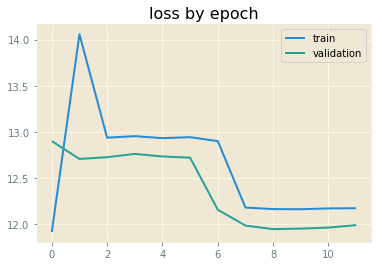

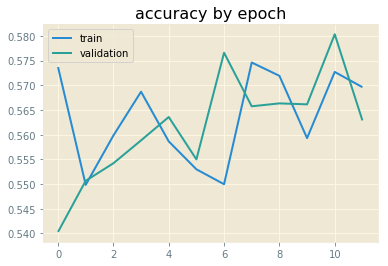

In [50]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot(np.arange(len(validation_losses)), validation_losses, label='validation')
plt.legend()
plt.title("loss by epoch")
plt.show()

plt.plot(np.arange(len(train_accuracies)), train_accuracies, label='train')
plt.plot(np.arange(len(validation_accuracies)), validation_accuracies, label='validation')
plt.legend()
plt.title("accuracy by epoch")
plt.show()

In [51]:
train_rezult_metrics

([11.91652320134324,
  14.057797601597924,
  12.93757155998046,
  12.953913700003234,
  12.932124133178045,
  12.943018998815829,
  12.899845383754343,
  12.180383149166023,
  12.163672082769015,
  12.162225164110247,
  12.171304172682074,
  12.173119969583258],
 [12.900287531903865,
  12.70689220608973,
  12.725959332583454,
  12.76136975935205,
  12.734130931577472,
  12.72051157785891,
  12.156668732218938,
  11.985064431319854,
  11.946930139222731,
  11.952377881913531,
  11.96327343348073,
  11.990512204095015],
 [0.5737004665834264,
  0.549845567457449,
  0.5598343957416048,
  0.5687060524413485,
  0.558651508181639,
  0.5529999342840245,
  0.5499769994085563,
  0.5746204902411777,
  0.5719261352434777,
  0.5593086679371755,
  0.5727147269501216,
  0.5696260760990997],
 [0.5403194006309149,
  0.5506703470031545,
  0.5542192429022083,
  0.558852523659306,
  0.5635843848580442,
  0.5550078864353313,
  0.5765970031545742,
  0.5657531545741324,
  0.5663446372239748,
  0.566147476340